### Importación de Librerías 

In [70]:
import cv2
from cv2 import WINDOW_NORMAL
from google.colab.patches import cv2_imshow
import numpy as np 
from matplotlib import pyplot as plt 
from skimage import exposure
from skimage import io
from skimage import data
from skimage.exposure import is_low_contrast
from google.colab import drive
from skimage.morphology import medial_axis, skeletonize
from sklearn.cluster import KMeans

### Acceso al google drive

In [71]:
 drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Dirrección de la imagen a procesar

In [72]:
nombre = '/content/drive/MyDrive/Colab Notebooks/fotos/msg906010869-3851.jpg'

Preprocesado de la imagen y detector de bordes

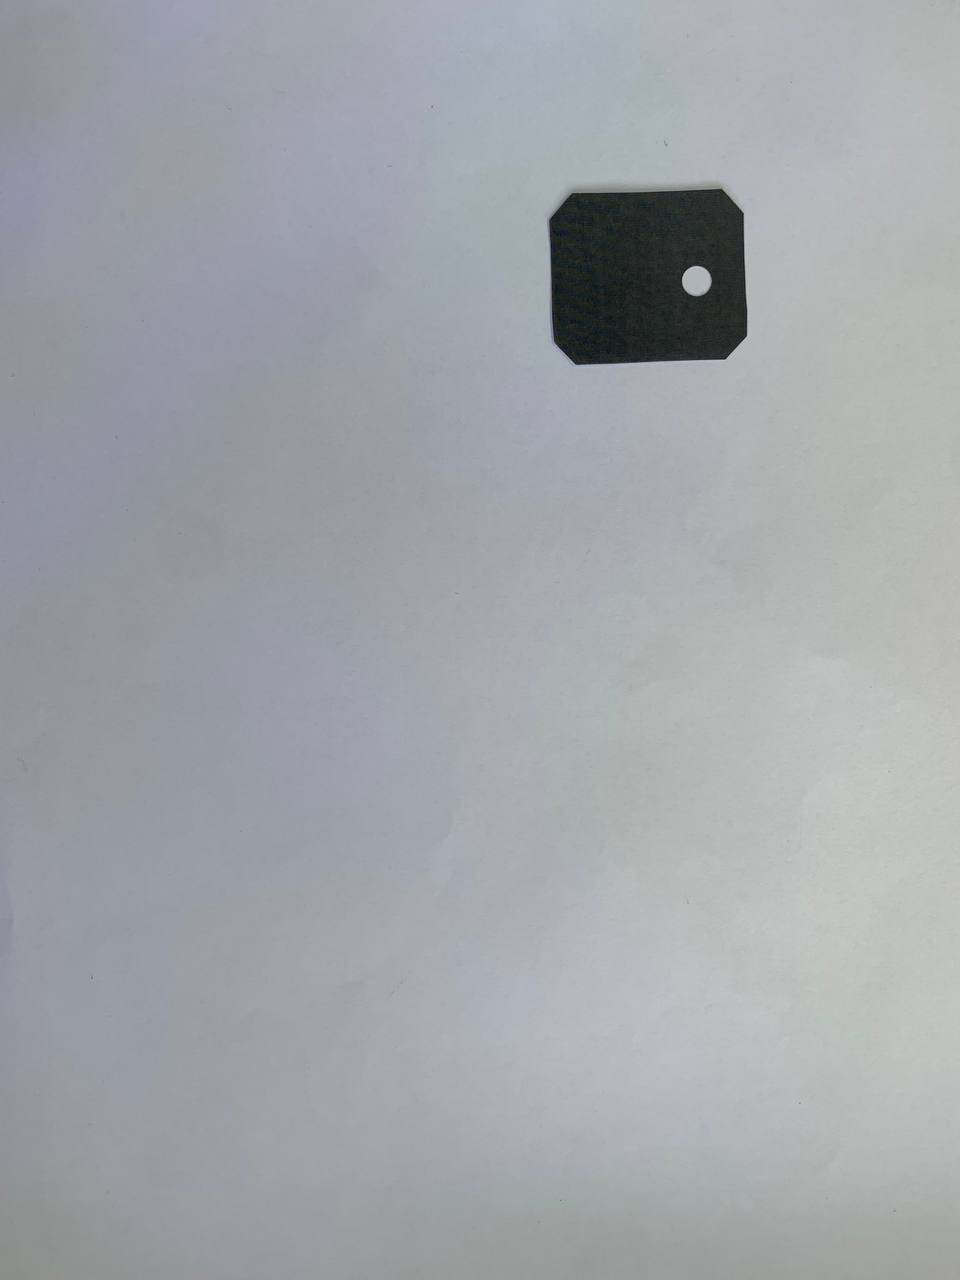

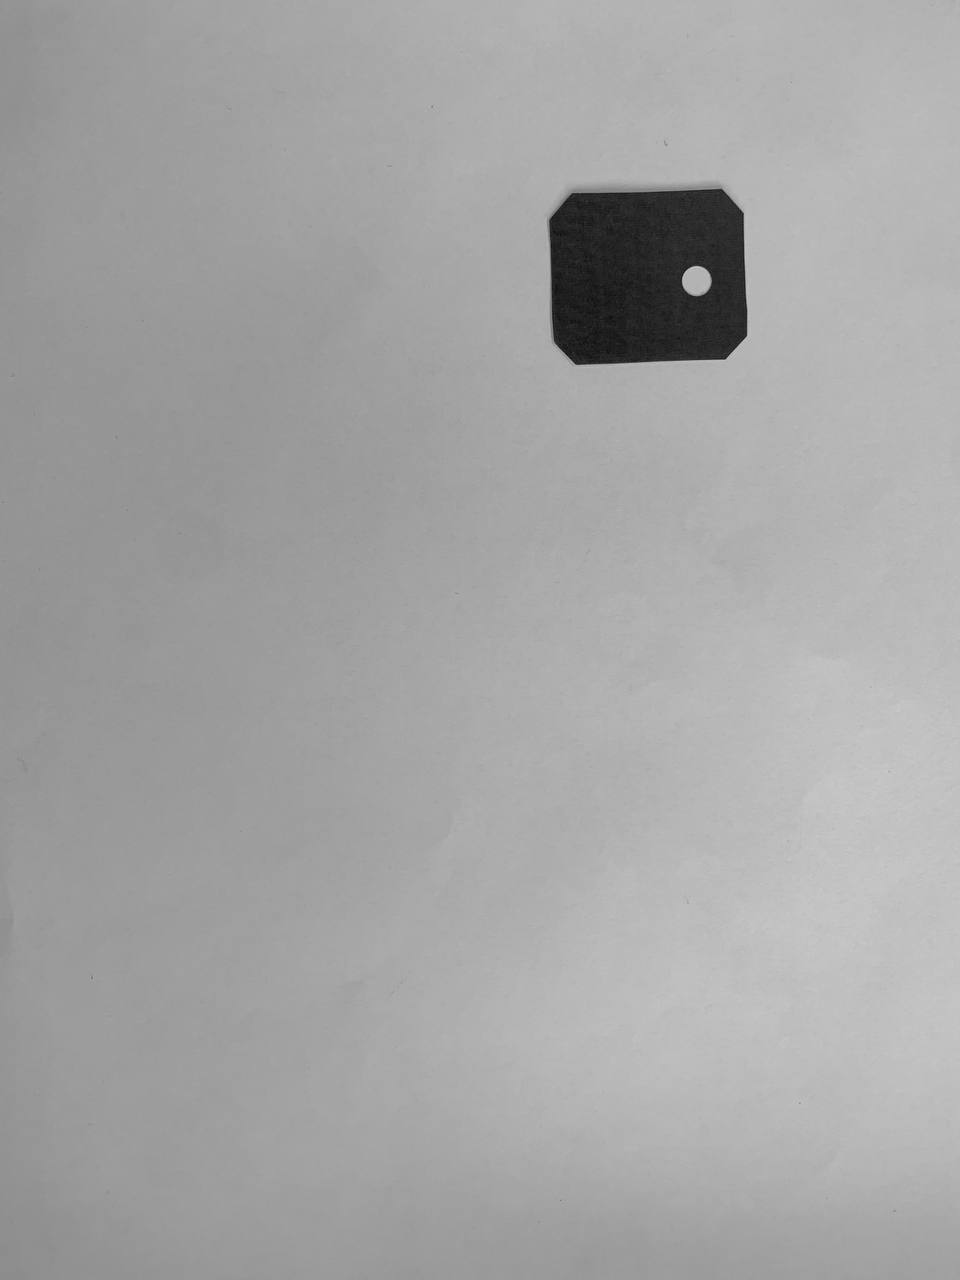

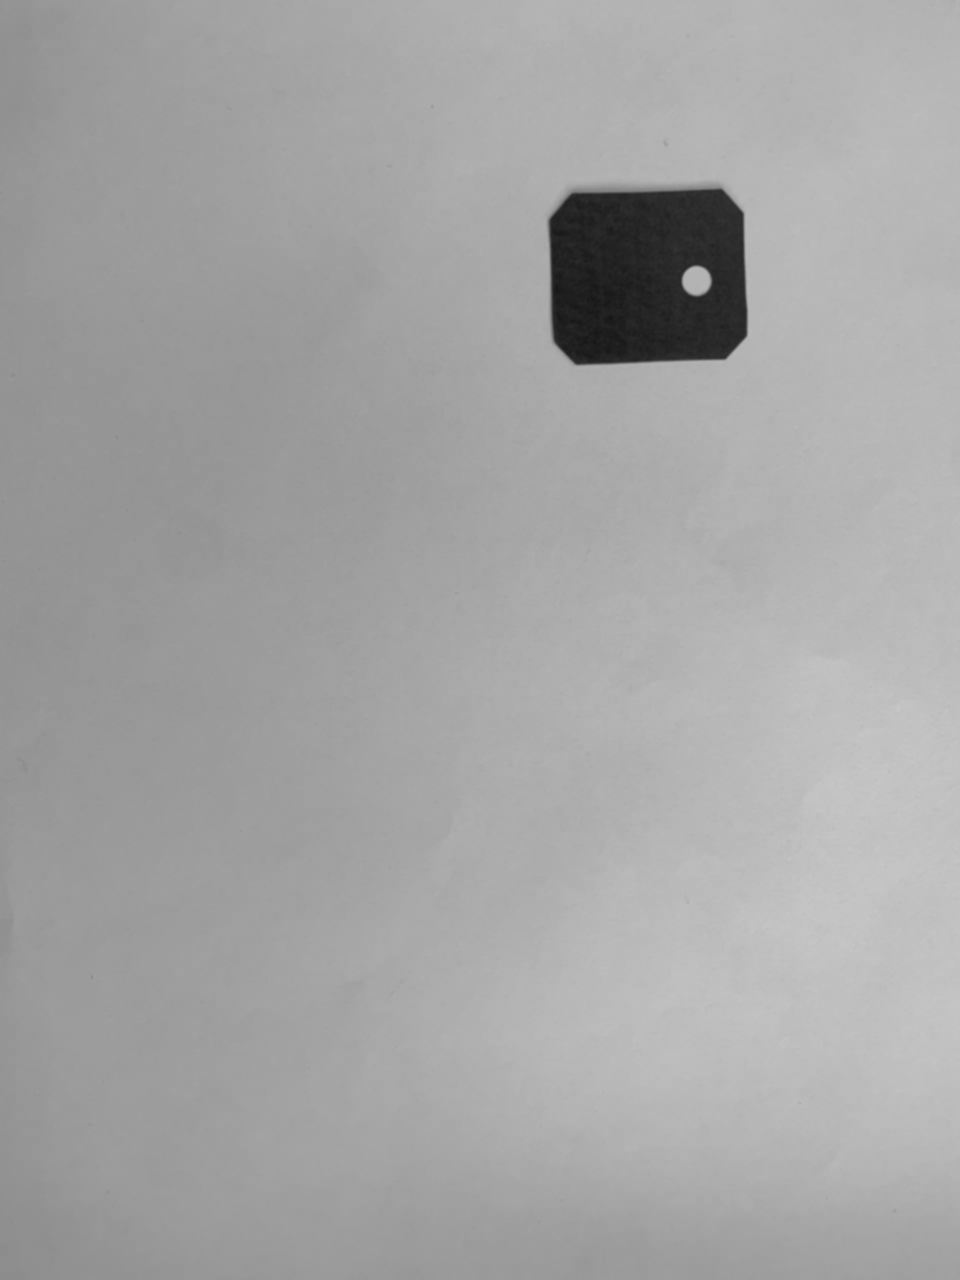

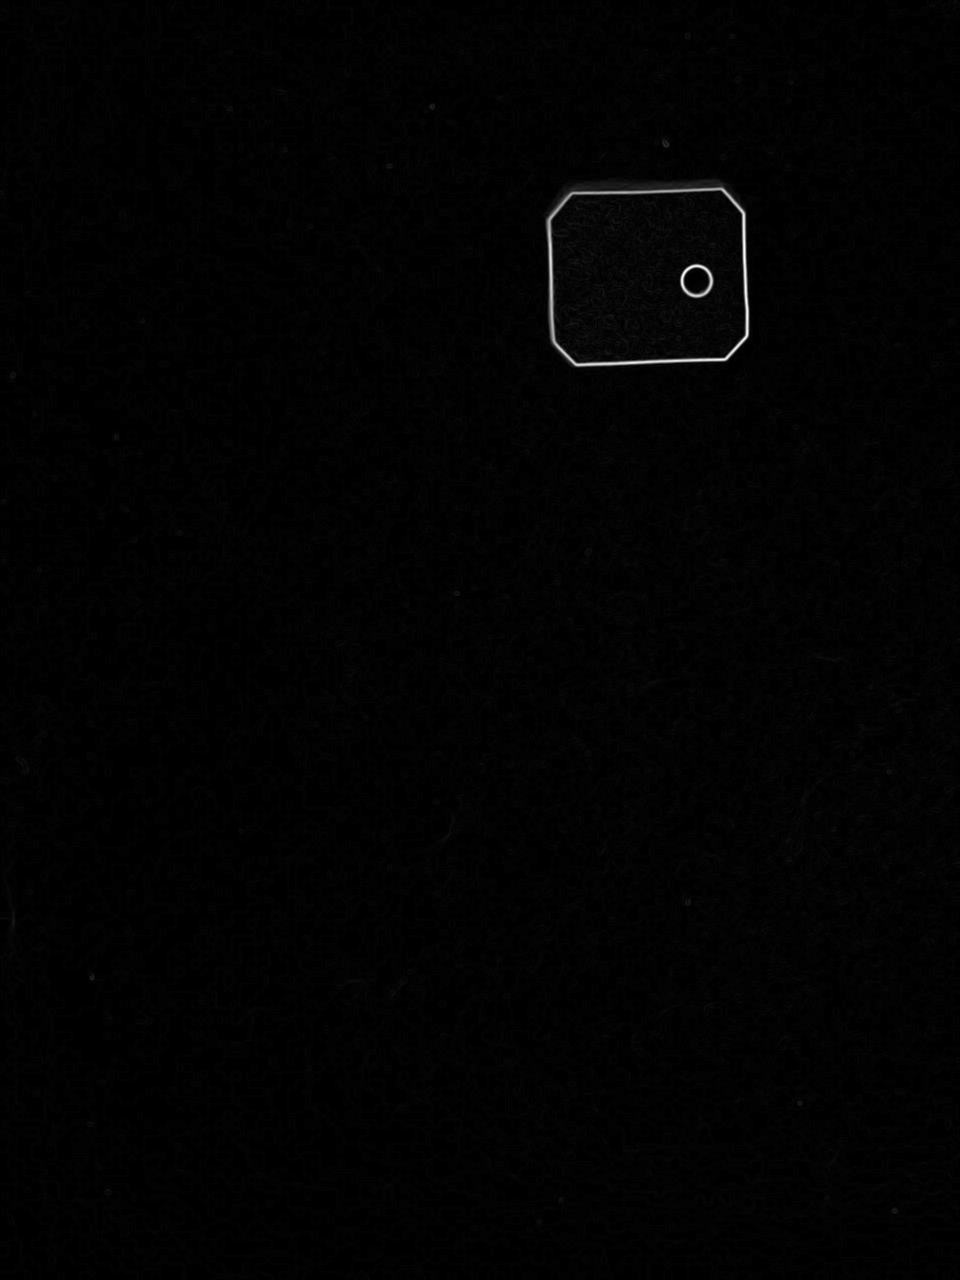

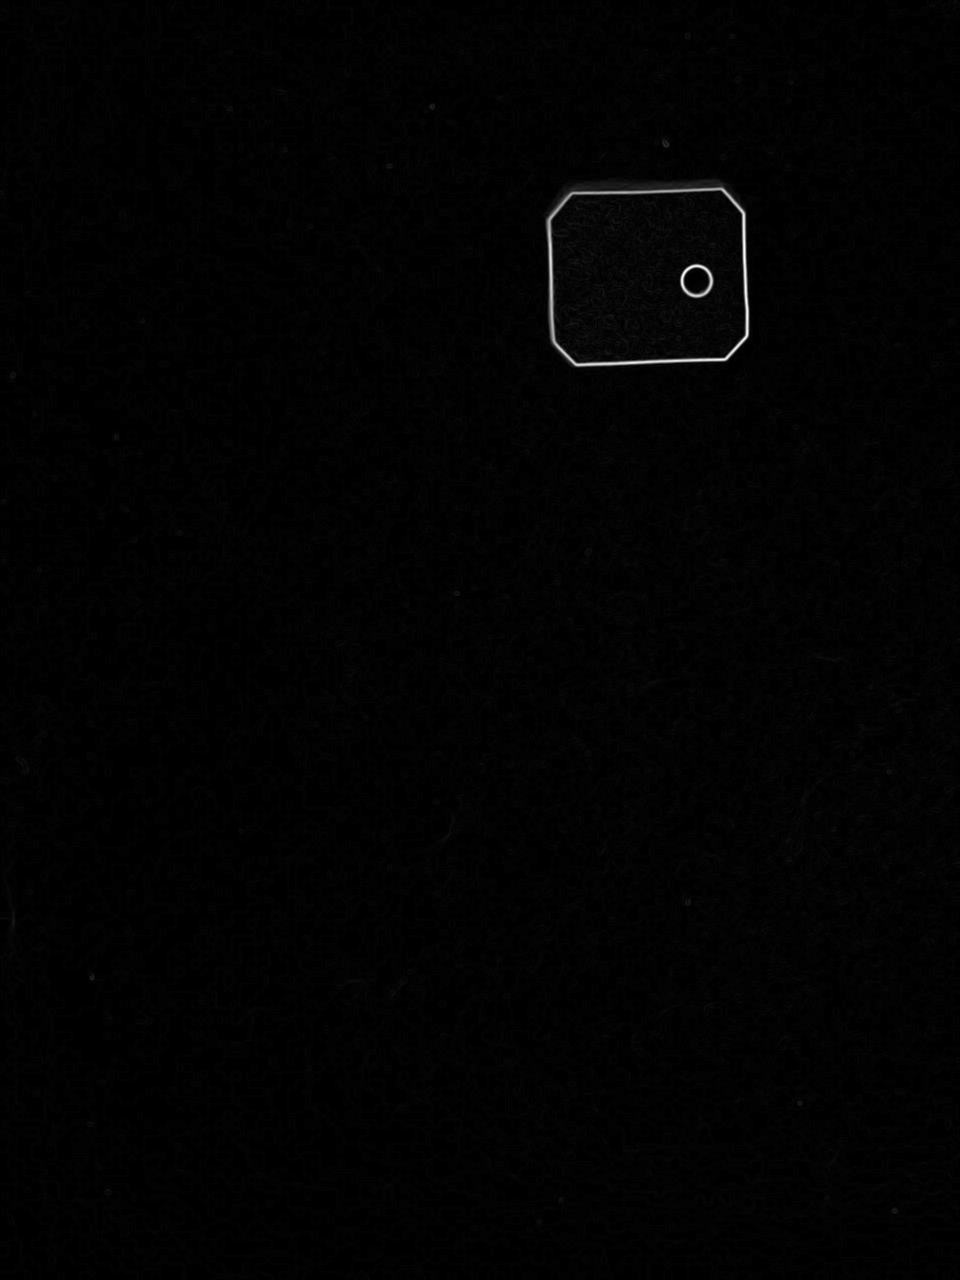

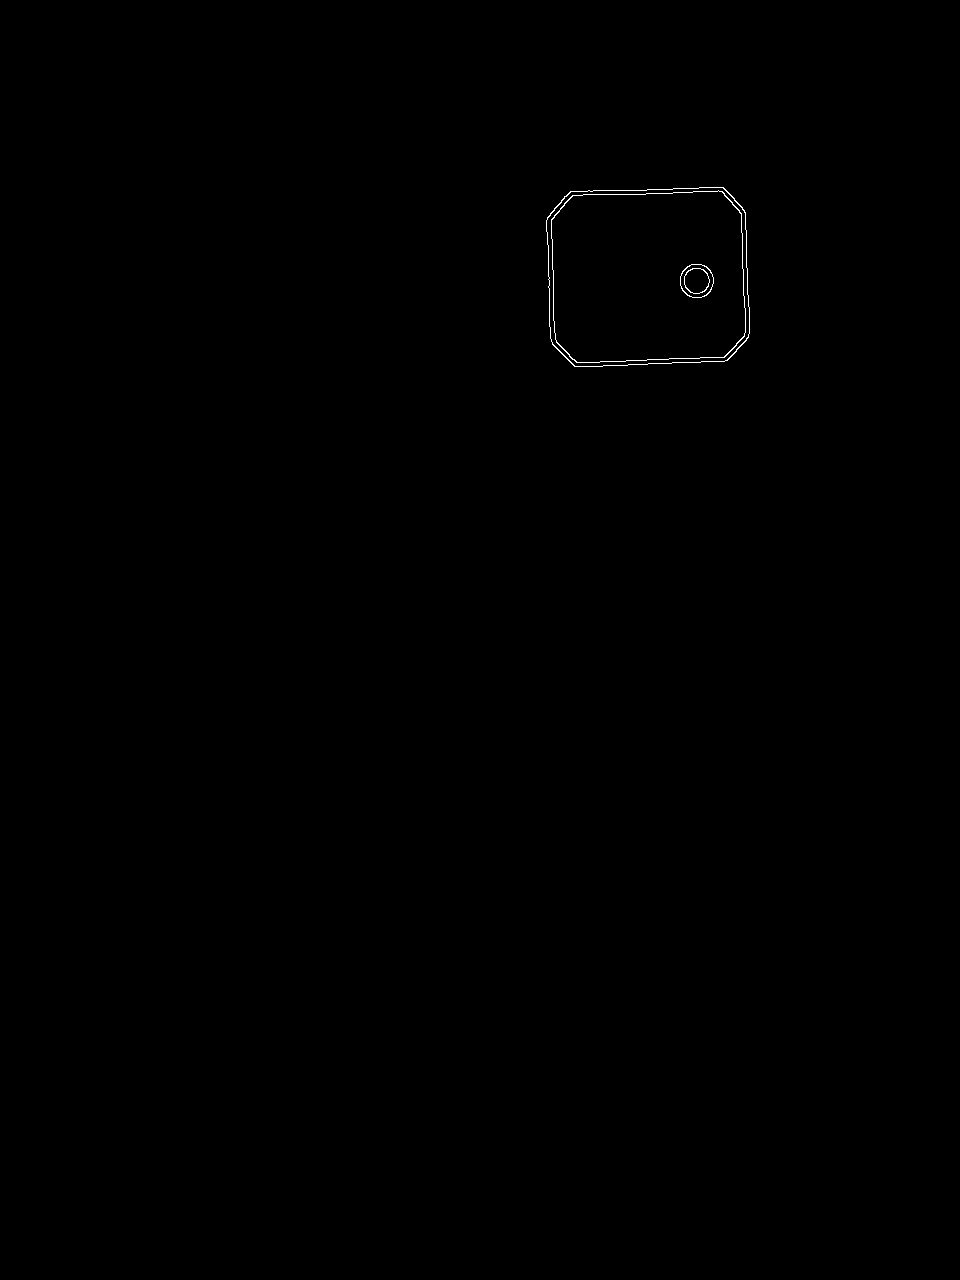

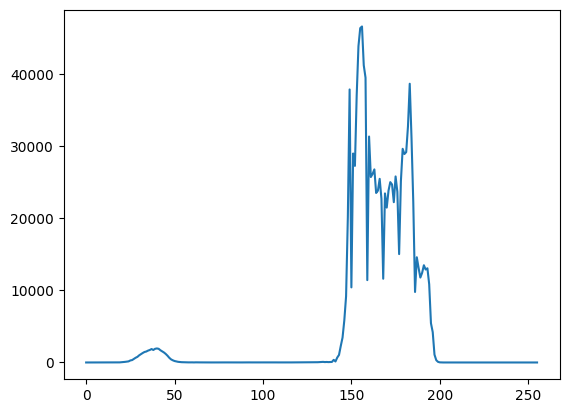

In [73]:

# Cargar la imagen de la señal de tráfico
img = cv2.imread(nombre)


cv2_imshow(img)
# Convertir la imagen a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray)

hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.plot(hist)
# Aplicar un filtro Gaussiano para suavizar la imagen
blur = cv2.GaussianBlur(gray, (5, 5), 0)

cv2_imshow(blur)
# Aplicar el operador Sobel en la dirección X
sobel_x = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)

# Aplicar el operador Sobel en la dirección Y
sobel_y = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)

# Obtener la magnitud de los gradientes
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

# Normalizar la magnitud de los gradientes para mostrarlos correctamente
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

cv2_imshow(gradient_magnitude)

blur = cv2.GaussianBlur(gradient_magnitude, (5, 5), 0)
blur = cv2.GaussianBlur(blur, (5, 5), 0)
cv2_imshow(gradient_magnitude)

edges = cv2.Canny(blur, 60, 255)

# Realizar una dilatación en los bordes
kernel = np.ones((3, 3), np.uint8)
edges2 = cv2.dilate(edges, kernel, iterations=1)
cv2_imshow(edges)

Codigo para detectar los circulos y presentarlos


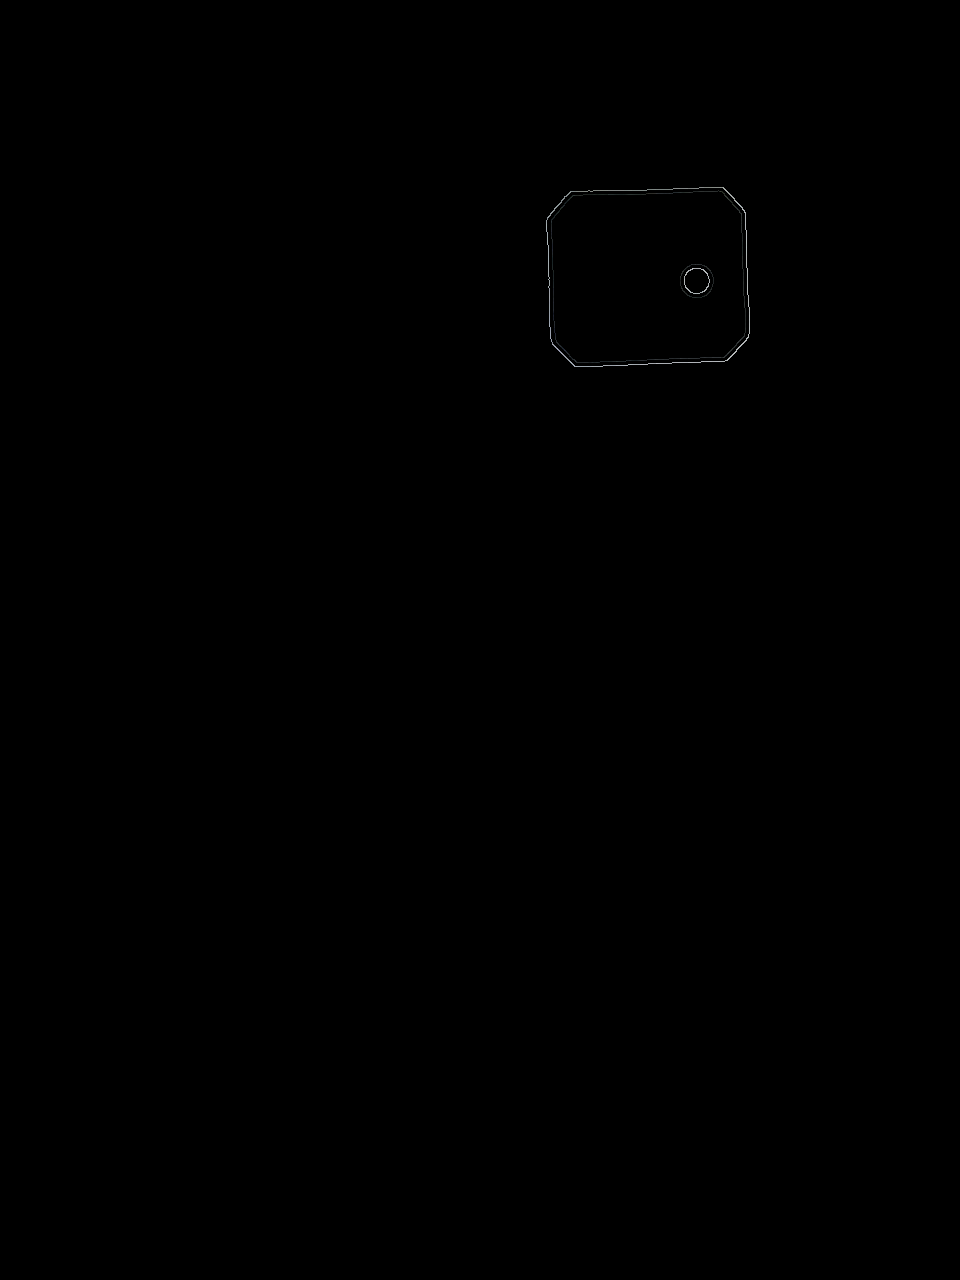

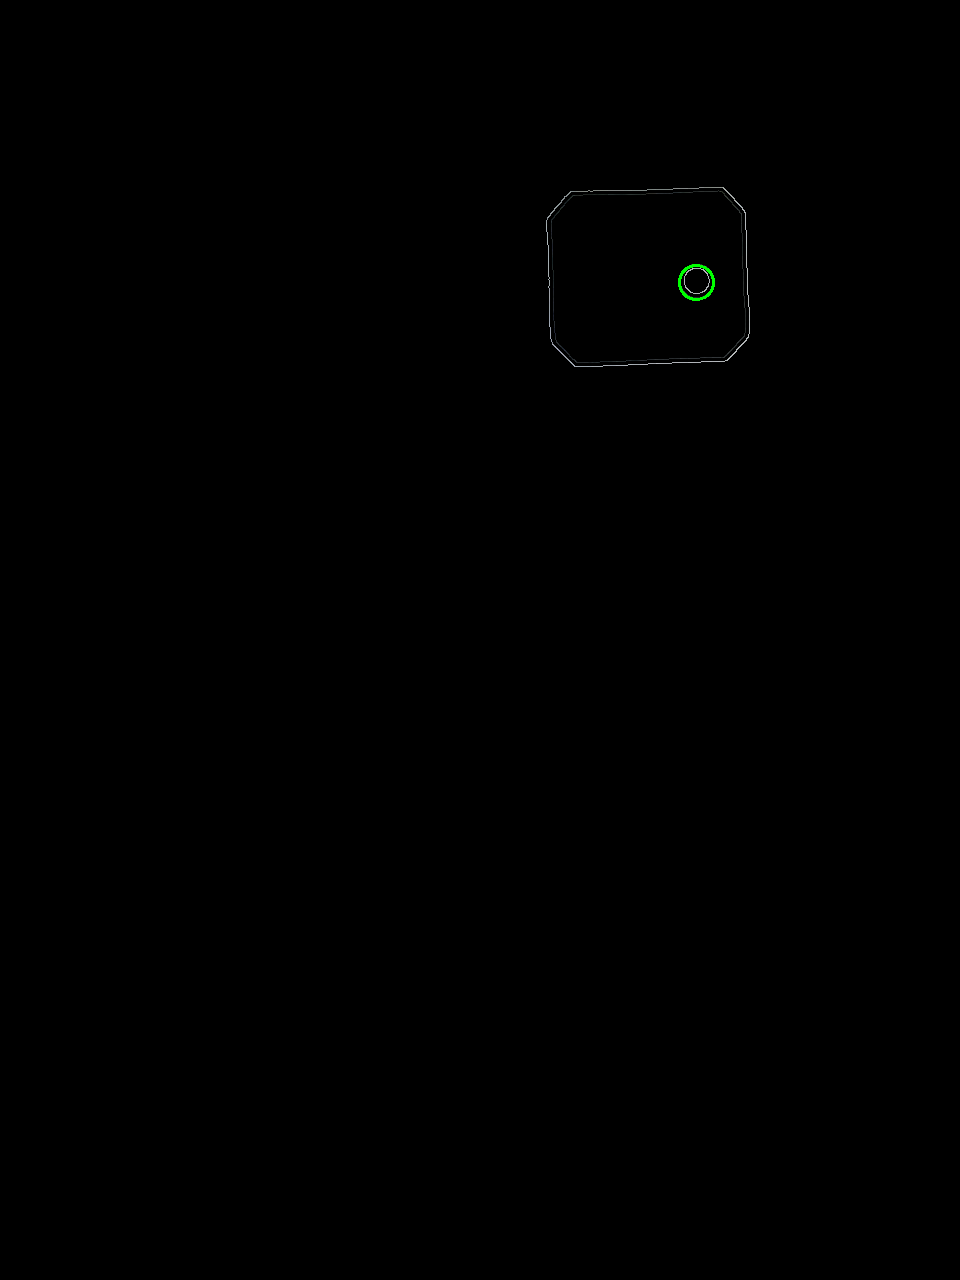

In [74]:
#Encontrar los contornos y dibujarlos en la imagen original

contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Crear una lista para almacenar los contornos encontrados
squares = []

# Recorrer todos los contornos encontrados
for contour in contours:
        squares.append(contour)

mask = np.zeros_like(gray)
# Dibujar los contornos encontrados sobre la imagen original
ar = cv2.drawContours(mask, squares, -1, (255, 255, 255), 1)
img[ar < 255] = 0

cv2_imshow(img)




# Detectar los círculos utilizando el método de detección de Hough Circles y dibujarlos en la imagen origianal
circles = cv2.HoughCircles(ar, cv2.HOUGH_GRADIENT, dp=1, minDist=30, param1=50, param2=30, minRadius=10, maxRadius=60)

   # Convertir las coordenadas y el radio a enteros
circles = np.round(circles[0, :]).astype(int)

# Dibujar los círculos detectados
for (x, y, r) in circles:
    cv2.circle(img, (x, y), r, (0, 255, 0), 2)

# Mostrar la imagen con los círculos detectados
cv2_imshow(img)




Delimitación de la ROI y detectar la falta de círculos

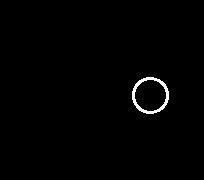

Presentes =  1  Ausentes =  4
centro:  0
arriba:  0
abajo:  0
derecha:  1
izquierda:  0


In [75]:
# Extraer una region de interes y dibujar los circulos en la region de interes
# Obtener las dimensiones de la imagen anterior
alto, ancho, _ = img.shape

# Crear una imagen totalmente negra del mismo tamaño
img_negra = np.zeros((alto, ancho, 3), dtype=np.uint8)

# Dibujar los círculos en la imagen negra
for (x, y, r) in circles:
    cv2.circle(img_negra, (x, y), r, (0, 255, 0), 2)


# Seleccionar el primer contorno encontrado
contour = squares[1]

# Obtener las coordenadas y dimensiones del rectángulo delimitador del contorno
x, y, w, h = cv2.boundingRect(contour)

# Extraer la región de interés de la imagen utilizando indexación de matrices
roi = img_negra[y:y+h, x:x+w]
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
_, roi = cv2.threshold(roi, 30, 255, cv2.THRESH_BINARY)
cv2_imshow(roi)


#Detectar la prescencia o auscencia de los circulos
# Detectar los círculos utilizando el método de detección de Hough Circles
circles2 = cv2.HoughCircles(roi, cv2.HOUGH_GRADIENT, dp=1, minDist=10, param1=40, param2=20, minRadius=2, maxRadius=30)


# Convertir las coordenadas y el radio a enteros
circles2 = np.round(circles2[0, :]).astype(int)

# Contar los círculos
num_circles2 = len(circles2)

# Obtener las dimensiones de la imagen
alto, ancho = roi.shape

# Calcular el centro de la imagen
centro_x = ancho // 2
centro_y = alto // 2

central, arriba,abajo, derecha, izquierda = 0,0,0,0,0

#Detectar la presencia o ausencia de los circulos 
for i in (circles2): 
  x = centro_x - i[0] 
  y = centro_y - i[1]
  if (0<=np.abs(x)<=15 and 0<=np.abs(y)<=15): 
    central = 1
  elif(x<-15): 
      derecha = 1
  elif(x>15):
    izquierda =1
  elif(y<-15):
    abajo = 1
  elif(y>15):
    arriba = 1
  else:
    pass



print("Presentes = ", num_circles2 , " Ausentes = " , 5-num_circles2)
print("centro: " , central)
print("arriba: " , arriba)
print("abajo: " , abajo)
print("derecha: " , derecha)
print("izquierda: " , izquierda)

  


Saber si la imagen es cromática o acromática


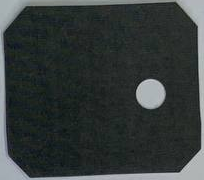

La imagen es un color acromático.


In [76]:
#Extraer una region de interes para evaluar si es acromatica o cromatica
img2 = cv2.imread(nombre)

#Se extrae una región de interes para evaluar el color cromatico o acromatico
mask2 = np.zeros_like(img2)
ar2 = cv2.drawContours(mask2, squares,1, (255, 255, 255), 300)

img2[ar2  < 255] = 0


# Seleccionar el primer contorno encontrado
contour = max(squares, key=cv2.contourArea)

# Obtener las coordenadas y dimensiones del rectángulo delimitador del contorno
x, y, w, h = cv2.boundingRect(contour)

# Extraer la región de interés de la imagen utilizando indexación de matrices
roi = img2[y:y+h, x:x+w]

# Mostrar la región de interés
cv2_imshow(roi)



#Utilizar la saturacion para saber si la region de interes es croatica o acromatica 
    # Convertir la imagen a formato HSV
hsv_image = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Separar los canales de la imagen HSV
h, s, v = cv2.split(hsv_image)

    # Calcular el valor medio de la saturación
mean_saturation = np.mean(s)

    # Definir un umbral para determinar si es cromático o acromático
saturation_threshold = 75

    # Comparar el valor medio de la saturación con el umbral
if mean_saturation > saturation_threshold:
    print("La imagen es un color cromático.")
else:
    print("La imagen es un color acromático.")

Resumen de análisis


In [77]:
if mean_saturation > saturation_threshold:
    print("La imagen es un color cromático.")
else:
    print("La imagen es un color acromático.")

print("Presentes = ", num_circles2 , " Ausentes = " , 5-num_circles2)
print("centro: " , central)
print("arriba: " , arriba)
print("abajo: " , abajo)
print("derecha: " , derecha)
print("izquierda: " , izquierda)

La imagen es un color acromático.
Presentes =  1  Ausentes =  4
centro:  0
arriba:  0
abajo:  0
derecha:  1
izquierda:  0
